In [1]:
import os, glob, numpy as np, cv2, matplotlib.pyplot as plt, tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from sklearn.metrics import confusion_matrix, classification_report

c:\Users\VACB\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\VACB\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\VACB\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framework/

In [2]:
DATA_DIR   = r"C:\Users\VACB\OneDrive\Desktop\viemphoi\archive\chest_xray" 
IMG_SIZE   = (224, 224)   
BATCH      = 32
EPOCHS     = 50
OUT_DIR    = os.path.join(os.path.dirname(DATA_DIR), "gradcam_out")
CKPT_DIR   = os.path.join(os.path.dirname(DATA_DIR), "checkpoints")
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(CKPT_DIR, exist_ok=True)

BEST_MODEL = os.path.join(CKPT_DIR, "xception_pneu_best.h5")
CSV_LOG    = os.path.join(CKPT_DIR, "train_log.csv")

In [3]:
# data
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.10,
    horizontal_flip=True
)
val_test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_flow = train_gen.flow_from_directory(
    os.path.join(DATA_DIR, "train"),
    target_size=IMG_SIZE, color_mode='rgb',
    class_mode='binary', batch_size=BATCH, shuffle=True
)
val_flow = val_test_gen.flow_from_directory(
    os.path.join(DATA_DIR, "val"),
    target_size=IMG_SIZE, color_mode='rgb',
    class_mode='binary', batch_size=BATCH, shuffle=False
)
test_flow = val_test_gen.flow_from_directory(
    os.path.join(DATA_DIR, "test"),
    target_size=IMG_SIZE, color_mode='rgb',
    class_mode='binary', batch_size=BATCH, shuffle=False
)

class_indices = train_flow.class_indices
idx2class = {v:k for k,v in class_indices.items()}
print("Classes:", class_indices)

Found 5216 images belonging to 2 classes.
Found 47 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Classes: {'NORMAL': 0, 'PNEUMONIA': 1}


In [4]:
#2 model
base = Xception(include_top=False, weights="imagenet", input_shape=IMG_SIZE+(3,))
base.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.25)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.25)(x)
out = Dense(1, activation="sigmoid")(x)
model = Model(base.input, out)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [5]:
#call back
ckpt = ModelCheckpoint(BEST_MODEL, monitor="val_accuracy", save_best_only=True, mode="max", verbose=1)
es   = EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True, verbose=1)
rlr  = ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=4, verbose=1)
csv  = CSVLogger(CSV_LOG, append=False)

# 4 TRAIN PHASE 1 (freeze)
epochs_phase1 = 20
history1 = model.fit(
    train_flow, epochs=epochs_phase1, validation_data=val_flow,
    callbacks=[ckpt, es, rlr, csv], verbose=1)

c:\Users\VACB\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.8984 - loss: 0.2727
Epoch 1: val_accuracy improved from None to 0.91489, saving model to C:\Users\VACB\OneDrive\Desktop\viemphoi\archive\checkpoints\xception_pneu_best.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 109s 655ms/step - accuracy: 0.9162 - loss: 0.2060 - val_accuracy: 0.9149 - val_loss: 0.2165 - learning_rate: 0.0010
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.9401 - loss: 0.1378
Epoch 2: val_accuracy did not improve from 0.91489
163/163 ━━━━━━━━━━━━━━━━━━━━ 110s 674ms/step - accuracy: 0.9423 - loss: 0.1392 - val_accuracy: 0.8723 - val_loss: 0.2564 - learning_rate: 0.0010
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.9376 - loss: 0.1547
Epoch 3: val_accuracy did not improve from 0.91489
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 628ms/step - accuracy: 0.9398 - loss: 0.1475 - val_accuracy: 0.8511 - val_loss: 0.2612 - learning_rate: 0.0010
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.9516 - loss: 0.1268
Epoch 4: val_accuracy did not improve from 0.91489
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 659ms/step - accuracy: 0.9502 - loss: 0.1289 - val_accuracy: 0.9149 - val_loss: 0.1697 - learning_rate: 0.0010
Epo

163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 640ms/step - accuracy: 0.9503 - loss: 0.1258 - val_accuracy: 0.9362 - val_loss: 0.1864 - learning_rate: 0.0010
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.9568 - loss: 0.1179
Epoch 8: val_accuracy did not improve from 0.93617
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 629ms/step - accuracy: 0.9563 - loss: 0.1213 - val_accuracy: 0.9149 - val_loss: 0.2140 - learning_rate: 0.0010
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.9610 - loss: 0.1023
Epoch 9: val_accuracy did not improve from 0.93617

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 607ms/step - accuracy: 0.9551 - loss: 0.1170 - val_accuracy: 0.9362 - val_loss: 0.1529 - learning_rate: 0.0010
Epoch 10/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.9574 - loss: 0.1155
Epoch 10: val_accuracy did not improve from 0.93617
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 622ms/step - accuracy: 0.9597 - loss

In [6]:
#5 TRAIN PHASE 2 (fine-tune phần cuối)
base.trainable = True
for layer in base.layers[:-40]:  # mở khoảng 40 lớp cuối; có thể điều chỉnh 20–60 tùy GPU
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss="binary_crossentropy",
              metrics=["accuracy"])

history2 = model.fit(
    train_flow, epochs=EPOCHS, initial_epoch=epochs_phase1, validation_data=val_flow,
    callbacks=[ckpt, es, rlr, csv], verbose=1)

Epoch 21/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 929ms/step - accuracy: 0.9447 - loss: 0.1416
Epoch 21: val_accuracy did not improve from 0.93617
163/163 ━━━━━━━━━━━━━━━━━━━━ 158s 939ms/step - accuracy: 0.9597 - loss: 0.1125 - val_accuracy: 0.9362 - val_loss: 0.1423 - learning_rate: 1.0000e-04
Epoch 22/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 917ms/step - accuracy: 0.9725 - loss: 0.0706
Epoch 22: val_accuracy did not improve from 0.93617
163/163 ━━━━━━━━━━━━━━━━━━━━ 151s 923ms/step - accuracy: 0.9751 - loss: 0.0643 - val_accuracy: 0.9362 - val_loss: 0.1478 - learning_rate: 1.0000e-04
Epoch 23/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 908ms/step - accuracy: 0.9817 - loss: 0.0590
Epoch 23: val_accuracy improved from 0.93617 to 0.95745, saving model to C:\Users\VACB\OneDrive\Desktop\viemphoi\archive\checkpoints\xception_pneu_best.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 149s 915ms/step - accuracy: 0.9810 - loss: 0.0595 - val_accuracy: 0.9574 - val_loss: 0.1039 - learning_rate: 1.0000e-04
Epoch 24/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 912ms/step - accuracy: 0.9827 - loss: 0.0437
Epoch 24: val_accuracy improved from 0.95745 to 0.97872, saving model to C:\Users\VACB\OneDrive\Desktop\viemphoi\archive\checkpoints\xception_pneu_best.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 150s 920ms/step - accuracy: 0.9835 - loss: 0.0437 - val_accuracy: 0.9787 - val_loss: 0.1269 - learning_rate: 1.0000e-04
Epoch 25/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 928ms/step - accuracy: 0.9817 - loss: 0.0502
Epoch 25: val_accuracy did not improve from 0.97872
163/163 ━━━━━━━━━━━━━━━━━━━━ 153s 935ms/step - accuracy: 0.9852 - loss: 0.0416 - val_accuracy: 0.9362 - val_loss: 0.1922 - learning_rate: 1.0000e-04
Epoch 26/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 971ms/step - accuracy: 0.9904 - loss: 0.0265
Epoch 26: val_accuracy did not improve from 0.97872
163/163 ━━━━━━━━━━━━━━━━━━━━ 160s 978ms/step - accuracy: 0.9879 - loss: 0.0334 - val_accuracy: 0.9149 - val_loss: 0.2855 - learning_rate: 1.0000e-04
Epoch 27/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9889 - loss: 0.0324
Epoch 27: val_accuracy did not improve from 0.97872
163/163 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.9887 - loss: 0.0285 - val_accuracy: 0.9574 - val_loss: 0.0859 - learning_rate

In [19]:
model.summary(line_length=150, expand_nested=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━
┃ Layer (type)                               ┃ Output Shape                         ┃                 Param # ┃ Con
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━
│ input_layer (InputLayer)                   │ (None, 224, 224, 3)                  │                       0 │ -  
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ block1_conv1 (Conv2D)                      │ (None, 111, 111, 32)                 │                     864 │ inp
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ block1_conv1_bn (BatchNormalization)       │ (None, 111, 111, 32)                 │                     128 │ blo
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ block1_conv1_act (Activation)              │ (None, 111, 111, 32)                 │                       0 │ blo
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ block1_conv2 (Conv2D)                      │ (None, 109, 109, 64)                 │                  18,432 │ blo
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ block1_conv2_bn (BatchNormalization)       │ (None, 109, 109, 64)                 │                     256 │ blo
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ block1_conv2_act (Activation)              │ (None, 109, 109, 64)                 │                       0 │ blo
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ block2_sepconv1 (SeparableConv2D)          │ (None, 109, 109, 128)                │                   8,768 │ blo
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ block2_sepconv1_bn (BatchNormalization)    │ (None, 109, 109, 128)                │                     512 │ blo
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ block2_sepconv2_act (Activation)           │ (None, 109, 109, 128)                │                       0 │ blo
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ block2_sepconv2 (SeparableConv2D)          │ (None, 109, 109, 128)                │                  17,536 │ blo
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ block2_sepconv2_bn (BatchNormalization)    │ (None, 109, 109, 128)                │                     512 │ blo
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ conv2d (Conv2D)                            │ (None, 55, 55, 128)                  │                   8,192 │ blo
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ block2_pool (MaxPooling2D)                 │ (None, 55, 55, 128)                  │                       0 │ blo
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ batch_normalization (BatchNormalization)   │ (None, 55, 55, 128)                  │                     512 │ con
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ add (Add)                                  │ (None, 55, 55, 128)                  │                       0 │ blo
│                                            │          

 Total params: 21,123,883 (80.58 MB)

 Trainable params: 10,816,729 (41.26 MB)

 Non-trainable params: 10,307,152 (39.32 MB)

 Optimizer params: 2 (12.00 B)

In [9]:
#6 EVALUATE 
model.load_weights(BEST_MODEL)
test_loss, test_acc = model.evaluate(test_flow, verbose=1)
print(f"\n TEST \nLoss: {test_loss:.4f} | Acc: {test_acc:.4f}")

# CM + report
y_true = test_flow.classes
y_prob = model.predict(test_flow, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=[idx2class[0], idx2class[1]]))

20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 513ms/step - accuracy: 0.9022 - loss: 0.3698

 TEST 
Loss: 0.3698 | Acc: 0.9022

Confusion Matrix:
[[185  49]
 [ 12 378]]

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.94      0.79      0.86       234
   PNEUMONIA       0.89      0.97      0.93       390

    accuracy                           0.90       624
   macro avg       0.91      0.88      0.89       624
weighted avg       0.91      0.90      0.90       624



In [ ]:
# GRAD-CAM
LAST_CONV =  "block14_sepconv2_act"   # lớp conv cuối của Xception

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_array)
        target = preds[:, 0]  # binary sigmoid head
    grads = tape.gradient(target, conv_out)
    weights = tf.reduce_mean(grads, axis=(0,1,2))         # GAP trên gradient
    cam = tf.reduce_sum(weights * conv_out[0], axis=-1)   # weighted sum
    cam = tf.maximum(cam, 0)                               # ReLU
    cam = cam / (tf.reduce_max(cam) + 1e-8)
    return cam.numpy()

def gradcam_3panel(img_path, out_path=None, grid=8, alpha=0.45):
    # 1) load & preprocess
    pil = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    x = tf.keras.preprocessing.image.img_to_array(pil)[None, ...]
    x = preprocess_input(x)

    # 2) predict
    prob = float(model.predict(x, verbose=0)[0][0])
    label = "PNEUMONIA" if prob >= 0.5 else "NORMAL"
    prob_show = prob if prob >= 0.5 else (1-prob)

    # 3) heatmap
    heatmap = make_gradcam_heatmap(x, model, LAST_CONV)

    # 4) prepare 3 panes
    img_org = cv2.imread(img_path)
    img_org = cv2.resize(img_org, IMG_SIZE)

    # center CAM grid (for mid panel)
    cam_small = cv2.resize(heatmap, (grid, grid), interpolation=cv2.INTER_AREA)

    # overlay
    hm_u8 = np.uint8(255 * cv2.resize(heatmap, IMG_SIZE))
    hm_color = cv2.applyColorMap(hm_u8, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_org, 1 - alpha, hm_color, alpha, 0)

    # 5) plot like example
    plt.figure(figsize=(12,4))
    # left: input (grayscale look)
    gray = cv2.cvtColor(img_org, cv2.COLOR_BGR2GRAY)
    plt.subplot(1,3,1); plt.imshow(gray, cmap="gray"); 
    plt.title("test x-ray input"); plt.axis("off")

    # middle: 8x8 CAM grid
    plt.subplot(1,3,2); plt.imshow(cam_small, cmap="viridis", interpolation="nearest");
    plt.title("class activation map (Xception)"); plt.axis("off")

    # right: overlay
    plt.subplot(1,3,3); plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB));
    plt.title(f"superimposed CAM\npredicted: {label} (prob {prob_show:.3f})"); plt.axis("off")

    plt.tight_layout()
    if out_path:
        plt.savefig(out_path, dpi=150, bbox_inches="tight")
        plt.close()
    else:
        plt.show()

c:\Users\VACB\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


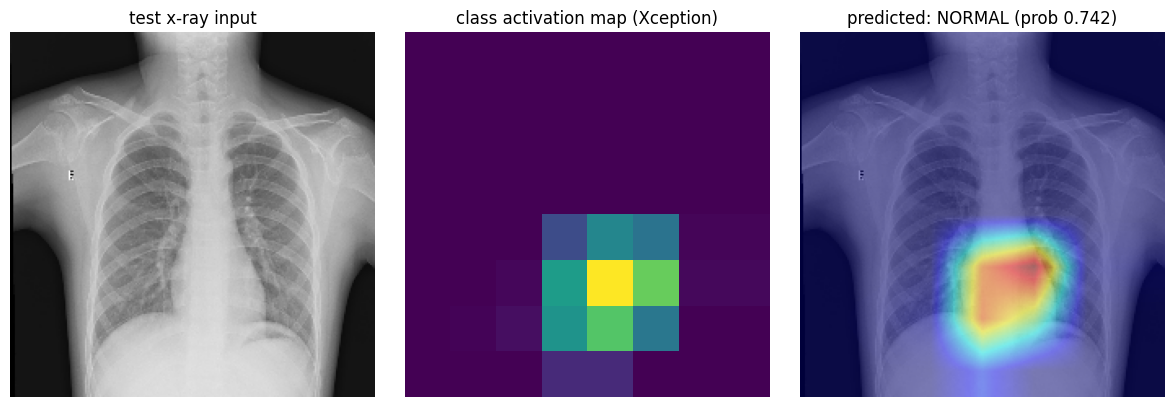

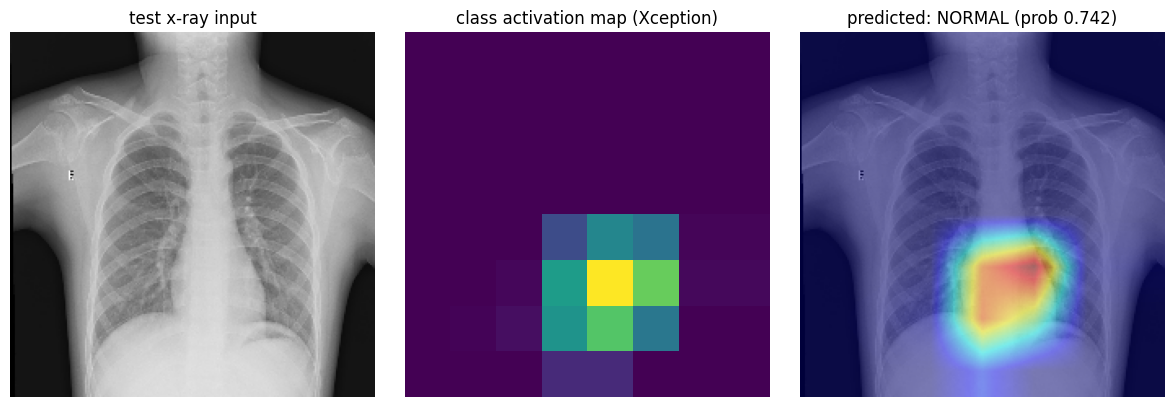

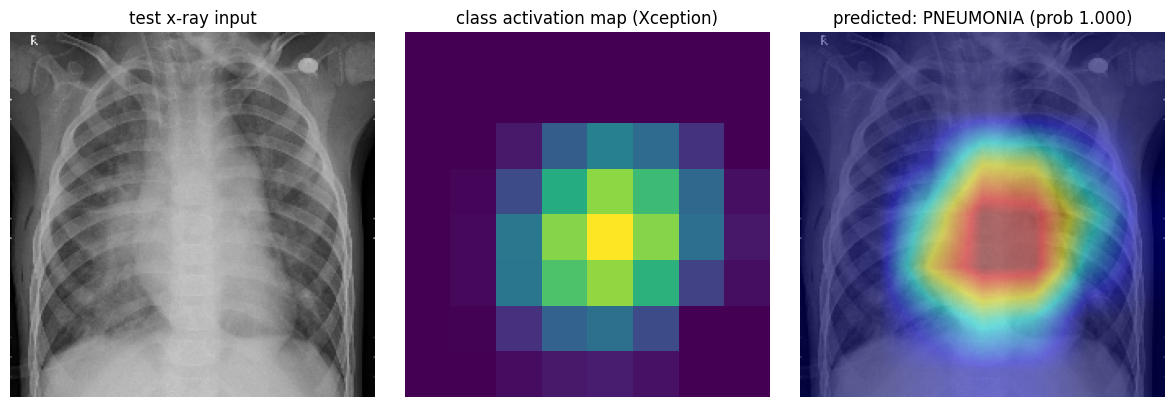

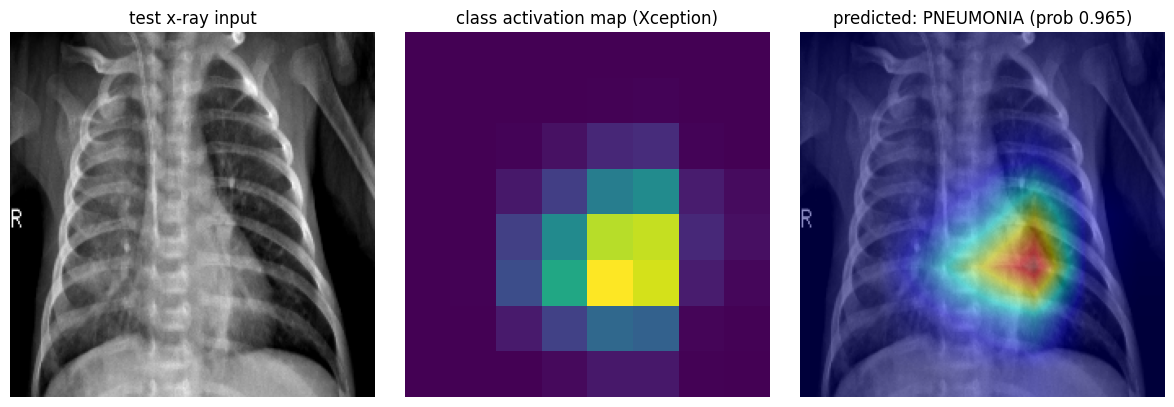

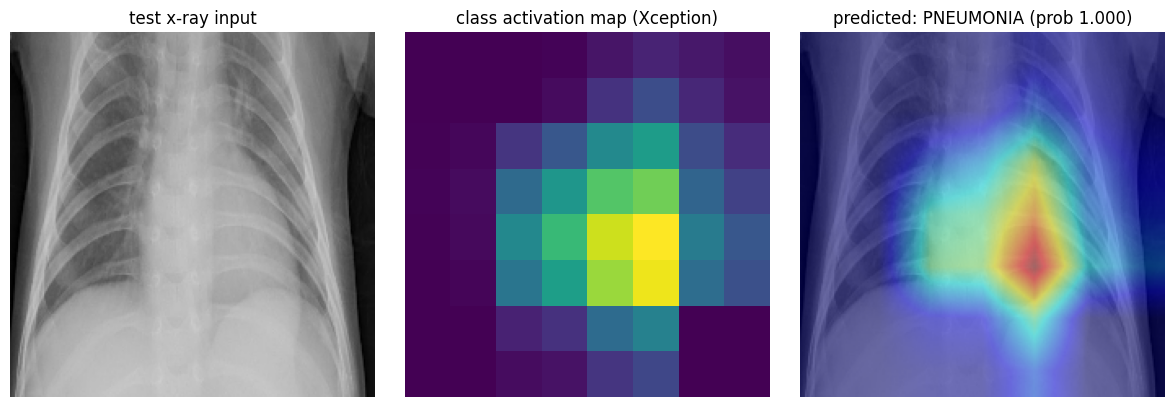

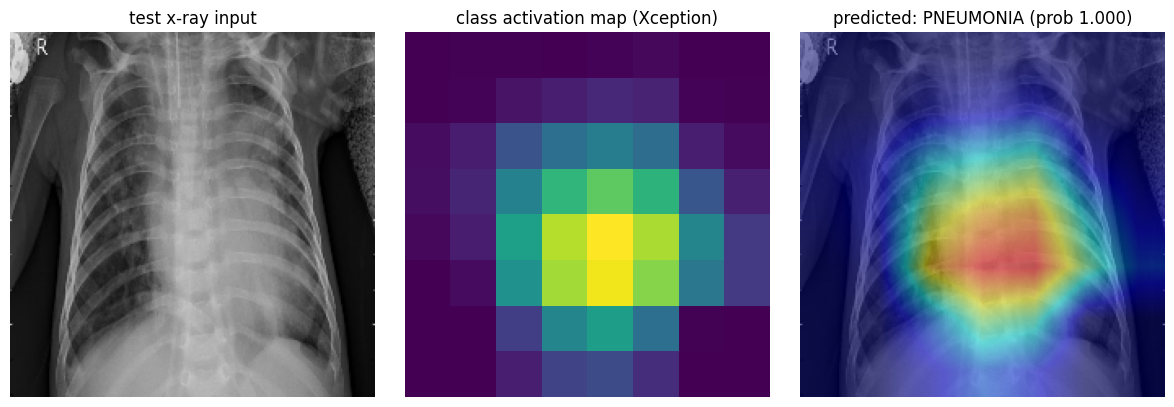

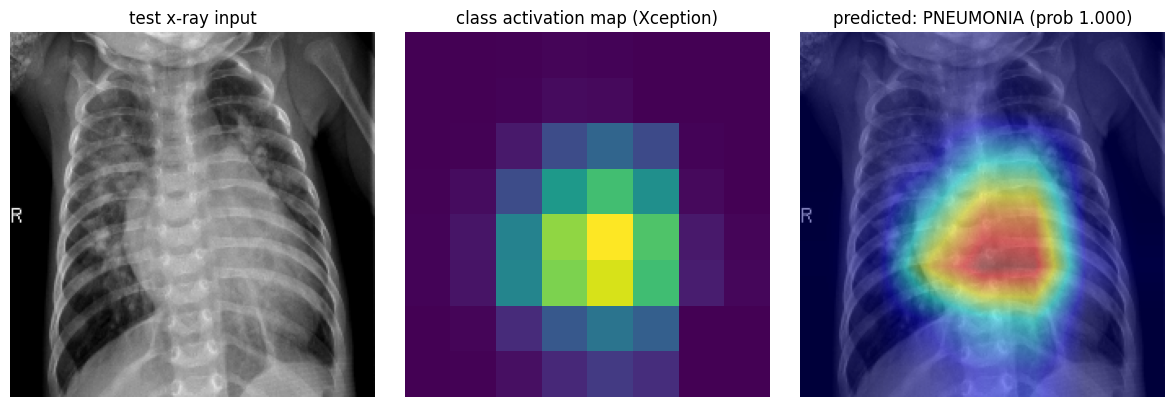

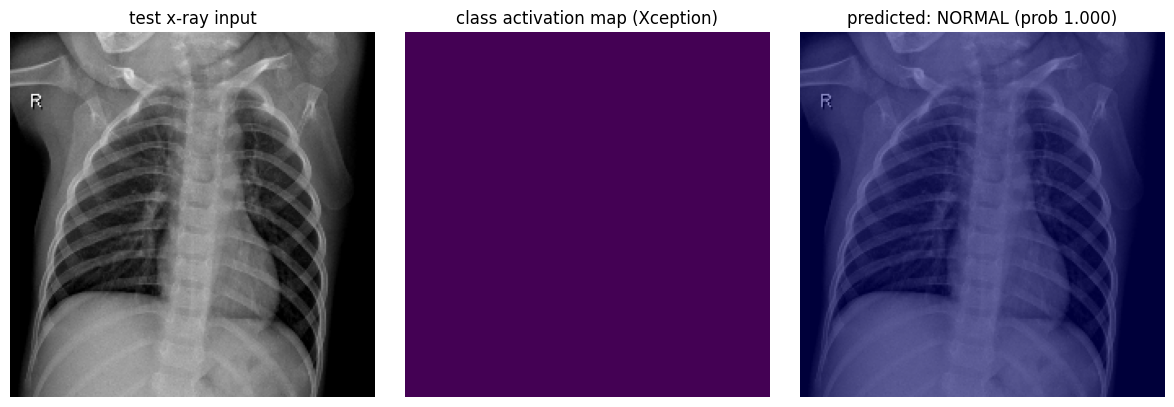

('NORMAL', 0.9999856159456613)

In [20]:
import os, numpy as np, cv2, matplotlib.pyplot as plt, tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.xception import preprocess_input

# load model 
MODEL_PATH = r"C:\Users\VACB\OneDrive\Desktop\viemphoi\archive\checkpoints\xception_pneu_best.h5"
model = load_model(MODEL_PATH)
REQ_SIZE = tuple(model.input_shape[1:3])         # (224, 224)

# Lớp conv cuối của Xception 
DEFAULT_LAST_CONV = "block14_sepconv2_act" #"block14_sepconv2_act"

def _pick_last_conv(m, fallback=DEFAULT_LAST_CONV):
    try:
        m.get_layer(fallback)
        return fallback
    except Exception:
        # Tự dò lớp conv cuối trong trường hợp tên khác
        for layer in reversed(m.layers):
            if "conv" in layer.name and len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Không tìm được lớp conv cuối cho Grad-CAM.")

def grad_pneu_cam(img_path, save_path=None, alpha=0.45, grid=8, threshold=0.5):
    """Vẽ 3 khung: input - CAM grid - overlay. Trả về (label, prob)."""
    assert os.path.exists(img_path), f"Không thấy ảnh: {img_path}"
    last_conv = _pick_last_conv(model)

    # 1) nạp & preprocess đúng kích thước model
    pil = tf.keras.preprocessing.image.load_img(img_path, target_size=REQ_SIZE, color_mode='rgb')
    x = tf.keras.preprocessing.image.img_to_array(pil)[None, ...]
    x = preprocess_input(x)

    # 2) dự đoán
    prob_raw = float(model.predict(x, verbose=0)[0][0])
    label = "PNEUMONIA" if prob_raw >= threshold else "NORMAL"
    prob  = prob_raw if prob_raw >= threshold else (1 - prob_raw)

    # 3) tính heatmap
    grad_model = tf.keras.models.Model([model.inputs],
                                       [model.get_layer(last_conv).output, model.output])
    with tf.GradientTape() as tape:
        conv_out, logits = grad_model(x)
        target = logits[:, 0]
    grads = tape.gradient(target, conv_out)
    weights = tf.reduce_mean(grads, axis=(0,1,2))
    cam = tf.reduce_sum(weights * conv_out[0], axis=-1)
    cam = tf.maximum(cam, 0) / (tf.reduce_max(cam) + 1e-8)
    cam = cam.numpy()

    # 4) overlay + vẽ 3 khung
    img_org = cv2.imread(img_path); img_org = cv2.resize(img_org, REQ_SIZE)
    hm8  = cv2.resize(cam, (grid, grid), interpolation=cv2.INTER_AREA)
    hm_u8 = np.uint8(255 * cv2.resize(cam, REQ_SIZE))
    hm_color = cv2.applyColorMap(hm_u8, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_org, 1 - alpha, hm_color, alpha, 0)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); 
    plt.imshow(cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB)); 
    plt.title("test x-ray input"); plt.axis("off")

    plt.subplot(1,3,2); 
    plt.imshow(hm8, cmap="viridis", interpolation="nearest"); 
    plt.title("class activation map (Xception)"); plt.axis("off")

    plt.subplot(1,3,3); 
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); 
    plt.title(f"predicted: {label} (prob {prob:.3f})"); plt.axis("off")

    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        plt.close()
    else:
        plt.show()

    return label, prob


grad_pneu_cam(r"C:\Users\VACB\OneDrive\Desktop\viemphoi\archive\chest_xray\vacb_random\NORMAL2-IM-0095-0001.jpeg")
grad_pneu_cam(r"C:\Users\VACB\OneDrive\Desktop\viemphoi\archive\chest_xray\vacb_random\NORMAL2-IM-0096-0001.jpeg")
grad_pneu_cam(r"C:\Users\VACB\OneDrive\Desktop\viemphoi\archive\chest_xray\vacb_random\person12_bacteria_47.jpeg")
grad_pneu_cam(r"C:\Users\VACB\OneDrive\Desktop\viemphoi\archive\chest_xray\vacb_random\person10_bacteria_43.jpeg")
grad_pneu_cam(r"C:\Users\VACB\OneDrive\Desktop\viemphoi\archive\chest_xray\vacb_random\person11_bacteria_45.jpeg")
grad_pneu_cam(r"C:\Users\VACB\OneDrive\Desktop\viemphoi\archive\chest_xray\vacb_random\person91_bacteria_447.jpeg")
grad_pneu_cam(r"C:\Users\VACB\OneDrive\Desktop\viemphoi\archive\chest_xray\vacb_random\person91_bacteria_445.jpeg")
grad_pneu_cam(r"C:\Users\VACB\OneDrive\Desktop\viemphoi\archive\chest_xray\vacb_random\NORMAL2-IM-1442-0001.jpeg")